In [2]:
import torch
import torch.nn as nn

# torchvision : 효율적인 이미지 변환을 위한 computer vision 용 라이브러리
from torchvision import models                # pretrained model을 불러오기 위한 패키지
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# device : gpu를 사용할 경우에는 'cuda', 그렇지 않을 경우에는 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 랜덤 시드 고정
# 실험 조건을 동일하게 설정하여 같은 input을 넣으면 같은 결과가 나올 수 있도록 함
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
batch_size = 128      # 배치크기
epochs = 5            # 학습 횟수
learning_rate = 0.01  # 학습률
num_classes = 10      # 총 클래스 수

In [5]:
train_dataset = datasets.CIFAR10(root='dataset/', train=True, download=True,
                                 transform=transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247, 0.243, 0.261))]))
test_dataset = datasets.CIFAR10(root='dataset/', train=False, download=True,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247, 0.243, 0.261))]))

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [6]:
# 첫번째 데이터 묶음 반환
images, labels = next(iter(train_loader))

In [7]:
def minmax_scale(input):
  min_val = np.min(input)
  max_val=np.max(input)
  out = (input-min_val)/(max_val-min_val)
  return out

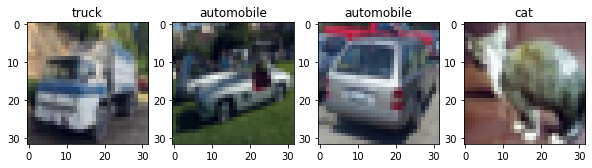

In [8]:
img = images.numpy().transpose(0,2,3,1)    # (batch, channel, height, width) -> (batch, height, width, channel)
img = minmax_scale(img)                    # 픽셀값 조정
label = labels.numpy()
classes = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(img[0])
plt.title(classes[label[0]])
plt.subplot(1,4,2)
plt.imshow(img[1])
plt.title(classes[label[1]])
plt.subplot(1,4,3)
plt.imshow(img[2])
plt.title(classes[label[2]])
plt.subplot(1,4,4)
plt.imshow(img[3])
plt.title(classes[label[3]])
plt.show()

In [9]:
# pretrained = True : pretrained weights 사용 / False : random weights 사용
resnet50 = models.resnet50(pretrained=True).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
num_in = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_in, num_classes).to(device)   # num_in = 2048 , num_classes = 10
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# cost function과 optimizer 정의
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(),lr=learning_rate)

In [13]:
# 모델 학습
resnet50.train() # 모델을 학습 모드로 설정

loss_list = []

for epoch in range(epochs):
  avg_loss = 0.0
  total_loss = 0.0
  for iter, data in enumerate(train_loader):
    
    # 매개변수 경사도 초기화
    optimizer.zero_grad()

    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # 순전파 - 예측값 계산
    output = resnet50(images)

    # loss 계산
    loss = criterion(output, labels)

    # backpropagation : 학습 가능한 매개변수에 대해 Loss의 변화도 계산
    loss.backward()

    # weights 갱신
    optimizer.step()
    avg_loss += loss.item()
    total_loss += loss.item()

    # iteration 100번째마다 loss 출력
    if (iter+1) % 100 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.5f}'.format(epoch, iter+1, len(train_loader), avg_loss/100.))
      avg_loss = 0.0
  loss_list.append(total_loss/(iter+1))  
print('\nLearning finished!')

Train Epoch: 0 [100/391]	Loss: 1.59601
Train Epoch: 0 [200/391]	Loss: 0.99561
Train Epoch: 0 [300/391]	Loss: 0.86544
Train Epoch: 1 [100/391]	Loss: 0.55167
Train Epoch: 1 [200/391]	Loss: 0.52896
Train Epoch: 1 [300/391]	Loss: 0.52964
Train Epoch: 2 [100/391]	Loss: 0.32160
Train Epoch: 2 [200/391]	Loss: 0.32695
Train Epoch: 2 [300/391]	Loss: 0.32741
Train Epoch: 3 [100/391]	Loss: 0.18135
Train Epoch: 3 [200/391]	Loss: 0.17924
Train Epoch: 3 [300/391]	Loss: 0.20101
Train Epoch: 4 [100/391]	Loss: 0.10089
Train Epoch: 4 [200/391]	Loss: 0.10866
Train Epoch: 4 [300/391]	Loss: 0.11819

Learning finished!


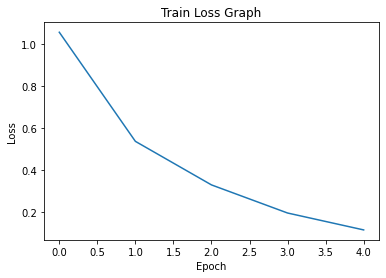

In [14]:
# Loss graph
plt.plot(range(0,epochs), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Graph')
plt.show()

Accuracy : 80.35%
Label:  deer
Prediction:  deer


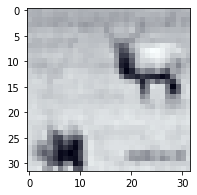

In [15]:
# 모델 성능 확인
with torch.no_grad(): # torch.no_grad(): gradient 계산을 수행하지 않음
  resnet50.eval()     # 모델을 evaluation mode로 설정
  accuracy = 0.0
  for iter, data in enumerate(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    output = resnet50(images)

    # 모델이 예측한 값과 실제 레이블인 labels를 비교
    # argmax 함수를 이용해 예측한 값 중 가장 확률이 높은 값을 예측 값으로 사용 (예) [0.1,0.05,0.7,0,0,0.15] -> 2
    pred = torch.argmax(output,1) == labels
    accuracy += pred.float().sum()
    
  print("Accuracy : {:.2f}%".format(100*accuracy/len(test_dataset)))

  # 테스트 데이터에서 무작위로 하나를 뽑아서 예측
  r = random.randint(0, len(test_dataset) - 1)
  X_single_data = test_dataset[r][0].unsqueeze(0).float().to(device)
  Y_single_data = test_dataset[r][1]

  print('Label: ', classes[Y_single_data])
  single_prediction = resnet50(X_single_data)
  print('Prediction: ', classes[torch.argmax(single_prediction, 1).item()])
  img = test_dataset[r][0].unsqueeze(0).numpy().transpose(0,2,3,1)
  img = minmax_scale(img)
  plt.figure(figsize=(3,3))
  plt.imshow(img[0])
  plt.show()

In [16]:
# 모델의 weight만 저장
torch.save(resnet50.state_dict(),'ResNet50_weight.pth')

In [17]:
# 모델 통째로 저장
torch.save(resnet50,'ResNet50.pth')

In [18]:
# 모델의 weight만 불러오기
checkpoint = torch.load('ResNet50_weight.pth', map_location = device)
resnet50.load_state_dict(checkpoint)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# 모델 통째로 불러오기
resnet50 = torch.load('ResNet50.pth', map_location=device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 